<a href="https://colab.research.google.com/github/Mrezakhodashenas/PhD-NN/blob/main/OutputSpikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
%reset -f

In [12]:
!pip install brian2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.8 MB/s eta 0:00:00


In [13]:
!pip install snntorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 1.9 MB/s eta 0:00:00


In [14]:
!pip install torchsummary

## set seeds for PyTorch and Numpy to ensure reproducibility:

In [15]:
import torch
import random
import numpy as np

# Set seeds for Python, Numpy, and Torch for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Additional steps if you're using GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [16]:
# imports
import pickle
import matplotlib.animation as animation
from scipy.integrate import simps
import torch
torch.cuda.empty_cache()
import os, sys, time, datetime, json, random
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import utils as utls
from snntorch import utils
from snntorch import surrogate
import numpy as np
import math
from sklearn.metrics import auc
from torchsummary import summary
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch.nn as nn


In [17]:
# /////////////////////# Building the Autoencoder
#-------------------DataLoaders.  using the MNIST dataset

# dataloader arguments
batch_size = 250
data_path='/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


# /////////////////////////////////# Define a transform
input_size = 32 # resizing the original MNIST from 28 to 32

transform = transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

#------------------------------------------- Load MNIST
# Training data
train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Testing data
test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



100%|██████████| 9912422/9912422 [00:00<00:00, 136383116.81it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 22490845.49it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 51290754.00it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5129383.08it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [8]:
# creating directories where we can save the original and reconstructed images for training and testing:
# create training/ and testing/ folders in the chosen path
if not os.path.isdir('figures/training'):
    os.makedirs('figures/training')
if not os.path.isdir('figures/binarytraining'):
    os.makedirs('figures/binarytraining')

if not os.path.isdir('figures/testing'):
    os.makedirs('figures/testing')
if not os.path.isdir('figures/binarytesting'):
    os.makedirs('figures/binarytesting')


if not os.path.isdir('Saved_Trained_Checkpoints/'):
    os.makedirs('Saved_Trained_Checkpoints/')

if not os.path.isdir('Output_Spikes/'):
    os.makedirs('Output_Spikes/')

In [9]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using {torch.cuda.get_device_name()} ({device})")
else:
    device = torch.device("cpu")
    print("Using CPU")


Using Tesla T4 (cuda)


### To manipulate and test:

In [10]:
class SAE(nn.Module):
    def __init__(self):
        super().__init__()


        # Encoder
        self.encoder = nn.Sequential(
                            nn.Conv2d(1, 32, 3,padding = 1,stride=2), # Conv Layer 1
                            # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1,
                                # bias=True, padding_mode='zeros',  device=None, dtype=None)
                            nn.BatchNorm2d(32),
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            # snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh), #SNN TORCH LIF NEURON
                            nn.Conv2d(32, 64, 3,padding = 1,stride=2), # Conv Layer 2
                            nn.BatchNorm2d(64),
                            # snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh), #SNN TORCH LIF NEURON
                            # snn.Alpha(alpha=alpha1, beta=beta1, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.Conv2d(64, 128, 3,padding = 1,stride=2), # Conv Layer 3
                            nn.BatchNorm2d(128),
                            # snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh), #SNN TORCH LIF NEURON
                            # snn.Alpha(alpha=alpha11, beta=beta11, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.Flatten(start_dim = 1, end_dim = 3), #Flatten convolutional output
                            nn.Linear(128*4*4, latent_dim), # Fully connected linear layer
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh)
                            # snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh)
                            )


        self.latent_dim = latent_dim #dimensions of the encoded z-space data

        #ve from the flattened encoded representation (latent_dim) back to a tensor representation to
            # use in transposed convolution.
          # To do so, we need to run an additional fully-connected linear layer transforming the data back into a tensor of 128 x 4 x 4:

        self.linearNet= nn.Sequential(
                                      nn.Linear(latent_dim,128*4*4),
                                      snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh))
                                      #snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh))




      #  The decoder, with three transposed convolutional (nn.ConvTranspose2d) layers and one linear output layer.
      # Although we converted the latent data back into tensor form for convolution, we still need to Unflatten it to a tensor of 128 x 4 x 4,
        # as the input to the network is 1 dimensional.  This is done using nn.Unflatten in the first line of the Decoder:
        # Decoder:
        self.decoder = nn.Sequential(
                            nn.Unflatten(1,(128,4,4)), #Unflatten data from 1 dim to tensor of 128 x 4 x 4
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            # snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.ConvTranspose2d(128, 64, 3,padding = 1,stride=(2,2),output_padding=1),
                            nn.BatchNorm2d(64),
                            # snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            # snn.Alpha(alpha=alpha2, beta=beta2, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.ConvTranspose2d(64, 32, 3,padding = 1,stride=(2,2),output_padding=1),
                            nn.BatchNorm2d(32),
                            # snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            # snn.Alpha(alpha=alpha22, beta=beta22, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.ConvTranspose2d(32, 1, 3,padding = 1,stride=(2,2),output_padding=1),
                            # snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,output=True,threshold=20000) #so membrane can be trained
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,output=True,threshold=thresh) #---------------------------------------------- ADDED
                            # snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,output=True,threshold=20000) #so membrane can be trained
                            )
        # final Leaky layer, our spiking threshold (thresh) is set extremely high. This is a neat trick in snnTorch, which allows the neuron
        # membrane in the final layer to continuously be updated, without ever reaching a spiking threshold.

        # using the membrane potential output from the final layer for the image reconstruction.
            # snnTorch allows us to use either the spikes or membrane potential of each neuron in training.


    def forward(self, x):
        utils.reset(self.encoder) #need to reset the hidden states of LIF
        utils.reset(self.decoder)
        utils.reset(self.linearNet)

    #-----------------------------encode
        spk_mem=[];
        spk_rec=[];
        spk_rec_syn=[];
        encoder_mem=[];
        spk_rec_dec=[];
        spk_mem_dec=[];
        for step in range(num_steps): #for t in time
            spk_x, mem_x = self.encode(x) #Output spike trains and neuron membrane states
            spk_rec.append(spk_x)
            spk_mem.append(mem_x)

        spk_rec=torch.stack(spk_rec,dim=2) # stack spikes in second tensor dimension
        spk_mem=torch.stack(spk_mem,dim=2) # stack membranes in second tensor dimension
# torch.stack joins (concatenates) a sequence of tensors (two or more tensors) along a new dimension.
        # print("Size of spk_rec:", spk_rec.size())   # Size of spk_rec: torch.Size([250, 32, 5])
        # print("Size of spk_mem:", spk_mem.size()) # Size of spk_mem: torch.Size([250, 32, 5])
        # out_en = spk_rec[:,:,-1]     #//////////////////////////////////////ADDED---------------- shows  batch size (250) different examples on (32) channel number
        out_en = spk_rec[0, :,:] #//////////////////////////////////////ADDED------------ latent dim (32) and time (num_steps)(5)
        # print("Size of out_en:", out_en.size()) #Size of out_en: torch.Size([250, 32])

    #------------------------------decode
        spk_mem2=[];
        spk_rec2=[];
        decoded_x=[];
        spk_x_dec=[];
        mem_x_dec=[];
        for step in range(num_steps): #for t in time
            # spk_x_dec, mem_x_dec = self.decode(spk_rec[...,step]) #//////////////////////////ADDED
            x_recon, x_mem_recon = self.decode(spk_rec[...,step])

            spk_rec2.append(x_recon)
            spk_mem2.append(x_mem_recon)

            # spk_rec_dec.append(spk_x_dec)   #//////////////////////////ADDED Size of spk_rec_dec: torch.Size([250, 1, 5, 32, 32])
            # spk_mem_dec.append(mem_x_dec)   #//////////////////////////ADDED

        # spk_rec_dec=torch.stack(spk_rec_dec,dim=2) #//////////////////////////ADDED
        # spk_mem_dec=torch.stack(spk_mem_dec,dim=2) #//////////////////////////ADDED
        spk_rec2=torch.stack(spk_rec2,dim=4)
        spk_mem2=torch.stack(spk_mem2,dim=4)

        # out = spk_mem2[:,:,:,:,-1] #return the membrane potential of the output neuron at t = -1 (last t)
        out = spk_rec2[:,:,:,:,-1] #  Size of out: torch.Size([250, 1, 32, 32])
        # out = spk_rec_dec[:,:,-1] #//////////////////////////ADDED  # Size of out: torch.Size([250, 1, 32, 32])
        # out = spk_rec_dec[:,0,:,-1] #//////////////////////////ADDED  # Size of out: torch.Size([250, 5, 32])
        # out = spk_rec_dec[:,0,0,:,-1] #//////////////////////////ADDED  # Size of out: torch.Size([250, 32])
        # out = spk_rec_dec[:,-1] #//////////////////////////ADDED  Size of out: torch.Size([250, 5, 32, 32])
        # out = spk_rec2[0,0,:,:] #//////////////////////////ADDED Now working with [250, 1, 32, 32]) because it is (torch.Size([32, 32, 5]))
        # out = spk_mem2[:,:,:,:,-1]  #//////////////////////////ADDED #  Size of out: torch.Size([250, 1, 32, 32])--------------- for one digit at the last time t

        # print("Size of out:", out.size())

        # Save the out_en tensor
        self.out_en = out_en
        self.out = out

        return out, out_en


    def encode(self,x):
      spk_latent_x, mem_latent_x = self.encoder(x)
      return spk_latent_x, mem_latent_x

    def decode(self,x):
        spk_x, mem_x = self.linearNet(x) #convert latent dimension back to total size of features in encoder final layer
        spk_x2, mem_x2 = self.decoder(spk_x)
        return spk_x2, mem_x2

In [11]:
# Training and Testing
# using MSE loss to compare the reconstructed image (x_recon) with the original image (real_img)
from torchvision.utils import save_image

spike_recordings = []
train_ber_rec = []
test_ber_rec = []
threshold_Real = 0.5
threshold_Recon = 0.5

def train(network, trainloader, opti, epoch):
    network=network.train()
    train_loss_hist=torch.zeros((1), dtype=dtype, device=device)
    train_avg_loss_rec=[]
    for batch_idx, (real_img, labels) in enumerate(trainloader):
        opti.zero_grad()
        real_img = real_img.to(device)
        labels = labels.to(device)
        out, out_en = network(real_img)  # Pass data into network and return reconstructed image and spk_rec
        x_recon, out = network(real_img)  # Pass data into network and return reconstructed image and spk_rec
        #Calculate loss
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
          loss_val += F.mse_loss(x_recon, real_img)
        train_loss_hist += (loss_val.item())/num_steps
        avg_loss=train_loss_hist.mean()

        # # ---------------------------- Calculate Bit Error Rate (BER)
        real_img_binary = (real_img > threshold_Real).float()
        x_recon_binary = (x_recon > threshold_Recon).float()
        bit_errors = torch.sum(torch.abs(real_img_binary - x_recon_binary))
        total_pixels = real_img_binary.numel()  # Total number of pixels in the images
        bit_error_rate = bit_errors.item() / total_pixels
        train_ber_rec.append(bit_error_rate)  # Append BER to the list

        # Save binary images
        Error_bin = (torch.abs(x_recon_binary - real_img_binary))

        if batch_idx == len(trainloader)-1:
          if epoch in [0, 25, 49]:
            utls.save_image(real_img_binary, f'figures/binarytraining/ep{epoch}_inputs_binary.png')
            utls.save_image(x_recon_binary, f'figures/binarytraining/ep{epoch}_recon_binary.png')
            utls.save_image(Error_bin, f'figures/binarytraining/ep{epoch}_Error_bin.png')
        print(f'Train[{epoch}/{max_epoch}][{batch_idx}/{len(trainloader)}] Loss: {loss_val.item()}, ' f'BER : {bit_error_rate}')

        loss_val.backward()
        opti.step()
        train_loss_rec.append(loss_val.item())

        #Save reconstructed images every at the end of the epoch
        if batch_idx == len(trainloader)-1:
            utls.save_image((real_img+1)/2, f'figures/training/epoch{epoch}_finalbatch_inputs.png')
            utls.save_image((x_recon+1)/2, f'figures/training/epoch{epoch}_finalbatch_recon.png')
            train_auc = auc(np.arange(len(train_loss_rec)), train_loss_rec)
    return loss_val, train_loss_rec, train_auc , out, out_en  #, spk_rec_batches#, train_avg_loss_rec, #avg_loss #, train_loss_hist


# For Testing, not doing backpropagate, therefore no gradients are required and we use torch.no_grad():
#Testing Loop
def test(network, testloader, opti, epoch):
    network=network.eval()
    test_loss_hist=[]
    test_avg_loss_rec=[]
    test_avg_loss_hist = []

    spk_rec_test = []
    with torch.no_grad(): #no gradient this time
        for batch_idx, (real_img, labels) in enumerate(testloader):
            real_img = real_img.to(device)#
            labels = labels.to(device)
            out, out_en = network(real_img)  # Pass data into network and return reconstructed image and spk_rec
            x_recon , out = network(real_img)  # Pass data into network and return reconstructed image and spk_rec
            # average Loss:
            loss_val = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
              loss_val += F.mse_loss(x_recon, real_img)
            avg_loss=loss_val/num_steps
            test_loss_hist.append(loss_val.item())

            real_img_binary = (real_img > threshold_Real).float()
            x_recon_binary = (x_recon > threshold_Recon).float()
            bit_errors = torch.sum(torch.abs(real_img_binary - x_recon_binary))
            total_pixels = real_img_binary.numel()  # Total number of pixels in the images
            bit_error_rate = bit_errors.item() / total_pixels
            test_ber_rec.append(bit_error_rate)  # Append BER to the list

            # Save binary images
            Error_bin = (torch.abs(x_recon_binary - real_img_binary))

            if batch_idx == len(testloader)-1:
              if epoch in [0, 25, 49]:
                save_image(real_img_binary, f'figures/binarytesting/ep{epoch}_inputs_binary.png')
                save_image(x_recon_binary, f'figures/binarytesting/ep{epoch}_recon_binary.png')
                save_image(Error_bin, f'figures/binarytesting/ep{epoch}_Error_bin.png')
            # -------------------------------------------------------------------------------------------------

            print(f'Test[{epoch}/{max_epoch}][{batch_idx}/{len(testloader)}]  Loss: {loss_val.item()}, '  f'BER (test): {bit_error_rate}')

            test_loss_rec.append(loss_val.item())

            if batch_idx == len(testloader)-1:
                utls.save_image((real_img+1)/2, f'figures/testing/epoch{epoch}_finalbatch_inputs.png')
                utls.save_image((x_recon+1)/2, f'figures/testing/epoch{epoch}_finalbatch_recons.png')
                test_auc = auc(np.arange(len(test_loss_rec)), test_loss_rec)

    return loss_val, test_loss_rec, test_auc, out, out_en

for batch_spikes in spike_recordings:
    print(batch_spikes)


In [18]:
input_size = 32 #resize of mnist data (optional)

#setup GPU
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan(alpha=2.0)  # alternate surrogate gradient fast_sigmoid(slope=25)

train_loss_rec = []
test_loss_rec = []
train_loss_record = []
test_loss_record = []
train_avg_loss_rec=[]
test_avg_loss_rec=[]

  # Synaptic current and membrane potential decay exponentially with rates of alpha and beta
alpha=0.9
# beta_syn=0.0001
beta_syn=0.9

beta =0.9

num_steps=5
latent_dim = 32 #dimension of latent layer (how compressed we want the information)
thresh=1    #spiking threshold (lower = more spikes are let through)
# epochs=50
epochs=50
max_epoch=epochs

  #Define Network and optimizer
net=SAE()
net = net.to(device)

optimizer = torch.optim.AdamW(net.parameters(),
                            lr=0.0001,
                            betas=(0.9, 0.999),
                            weight_decay=0.001)

NameError: ignored

## for saving the out_en after each epoch:

In [13]:
checkpoint_path = "Saved_Trained_Checkpoints/"
Output_Spikes = "Output_Spikes/"

# Run training and testing
for e in range(epochs):
    train_loss = train(net, train_loader, optimizer, e)
    train_avg_loss_rec.append(sum(train_loss_rec) / len(train_loader))

    test_loss = test(net, test_loader, optimizer, e)
    test_avg_loss_rec.append(sum(test_loss_rec) / (len(test_loader)))

    # Save the model every 10 epochs
    if (e + 1) % 10 == 0:
        model_path = checkpoint_path + f"model_epoch_{e + 1}.pt"
        torch.save(net.state_dict(), model_path)

    #---------------------------------------------------------- Access the out_en tensor
    out_en = net.out_en
    out_en_numpy = out_en.cpu().detach().numpy()

    # Save with a different name for each epoch
    out_en_filename = Output_Spikes + f"out_en_epoch_{e + 1}.npy"
    np.save(out_en_filename, out_en_numpy)


    #-----------------------------------------------------------Access the out tensor
    out = net.out
    out_numpy = out.cpu().detach().numpy()

    # Save with a different name for each epoch
    out_filename = Output_Spikes + f"out_epoch_{e + 1}.npy"
    np.save(out_filename, out_numpy)



Streaming output truncated to the last 5000 lines.
Train[32/50][40/240] Loss: 0.23211383819580078, BER : 0.06483203125
Train[32/50][41/240] Loss: 0.21723401546478271, BER : 0.06033203125
Train[32/50][42/240] Loss: 0.21730715036392212, BER : 0.0600390625
Train[32/50][43/240] Loss: 0.22638069093227386, BER : 0.063
Train[32/50][44/240] Loss: 0.22329360246658325, BER : 0.06214453125
Train[32/50][45/240] Loss: 0.20864231884479523, BER : 0.057953125
Train[32/50][46/240] Loss: 0.20969223976135254, BER : 0.058140625
Train[32/50][47/240] Loss: 0.21579959988594055, BER : 0.060015625
Train[32/50][48/240] Loss: 0.2157127559185028, BER : 0.05994140625
Train[32/50][49/240] Loss: 0.20888330042362213, BER : 0.05869140625
Train[32/50][50/240] Loss: 0.2154541164636612, BER : 0.05991015625
Train[32/50][51/240] Loss: 0.22388112545013428, BER : 0.06239453125
Train[32/50][52/240] Loss: 0.21608756482601166, BER : 0.0601015625
Train[32/50][53/240] Loss: 0.21705366671085358, BER : 0.0605234375
Train[32/50][54/

In [14]:
# # Set the path for saving checkpoints
# checkpoint_path = "Saved_Trained_Checkpoints/"

#    #Run training and testing
# for e in range(epochs):
#   train_loss = train(net, train_loader, optimizer, e)
#   train_avg_loss_rec.append(sum(train_loss_rec) / len(train_loader))


#   test_loss = test(net,test_loader, optimizer, e)
#   test_avg_loss_rec.append(sum(test_loss_rec)/(len(test_loader)))

# # /////////////////////////////////////////////////////////////////////
#       # Save the model every 10 epochs
#   if (e + 1) % 10 == 0:
#     model_path = checkpoint_path + f"model_epoch_{e + 1}.pt"
#     torch.save(net.state_dict(), model_path)

# # After training
# # Access the out_en tensor
# out_en = net.out_en
# out_en_numpy = out_en.cpu().detach().numpy()
# np.save("out_en.npy", out_en_numpy)


In [15]:
# spike_data = np.load("out_en.npy")

# # cmap = plt.get_cmap("binary")

# plt.imshow(spike_data, aspect="auto")
# # plt.xlabel("Time Steps")
# # plt.ylabel("Neurons")
# plt.title("Spike Activity in out_en")
# # plt.colorbar(label="Spikes")

# filename = f"(out_en)_spike_activity_epoch_{epochs}_b_syn_{beta_syn}.pdf"
# plt.savefig(filename, format="pdf")

# plt.show()

In [16]:
# spike_data = np.load("out_en.npy")

# cmap = plt.get_cmap("binary")
# plt.imshow(spike_data, cmap=cmap, aspect="auto")
# # plt.xlabel("Time Steps")
# # plt.ylabel("Neurons")
# plt.title("Spike Activity in out_en")
# # plt.colorbar(label="Spikes")

# filename = f"(out_en)_spike_activity_epoch_{epochs}_b_syn_{beta_syn}_binary.pdf"
# plt.savefig(filename, format="pdf")
# plt.show()

# Encoder plotting each epochs output of out_en:

## Heatmap or Cmap plot of the Endoer spikes

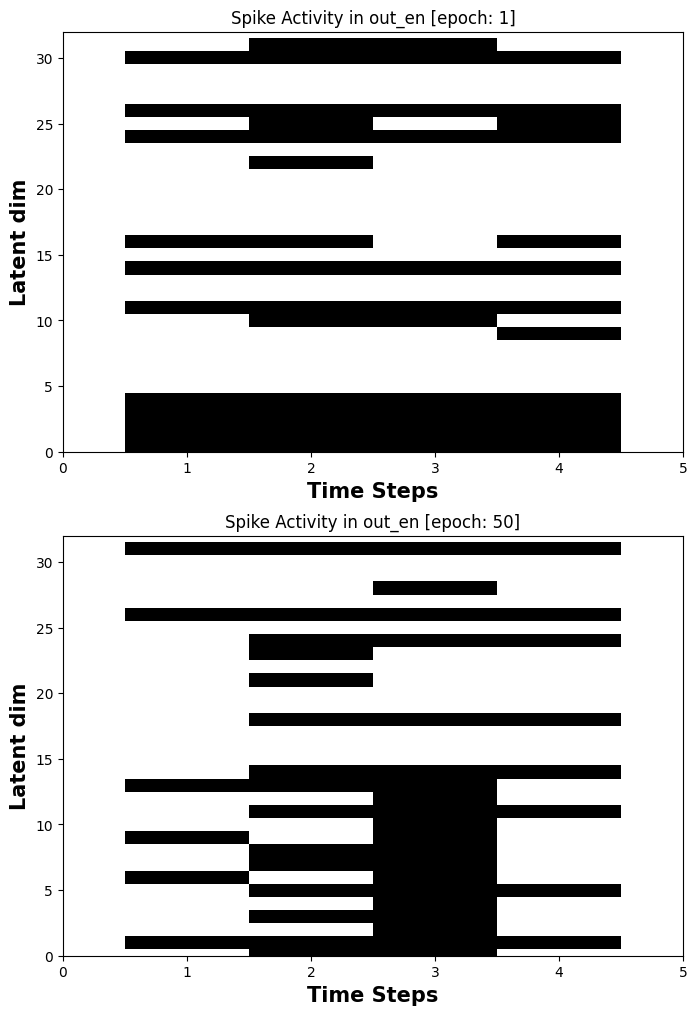

In [90]:
ax1_epoch = 1
spike_data1 = np.load(f"Output_Spikes/out_en_epoch_{ax1_epoch}.npy")
ax2_epoch = 50
spike_data2 = np.load(f"Output_Spikes/out_en_epoch_{ax2_epoch}.npy")

font_size = 15
font = {'weight': 'bold', 'size': 15}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# -------------------------------------------------------------------------------------- ax1
cmap = plt.get_cmap("binary")
ax1.imshow(spike_data1, cmap=cmap, aspect="auto")
ax1.set_xlim(0, spike_data1.shape[1])
ax1.set_ylim(0, spike_data1.shape[0])
# Label the axes
ax1.set_xlabel("Time Steps", fontweight="bold", fontdict=font)
ax1.set_ylabel("Latent dim", fontweight="bold", fontdict=font)
ax1.set_title("Spike Activity in out_en" + " [epoch: " + str(ax1_epoch) + "]")
# ax1.legend(["epoch: " + str(ax1_epoch)], frameon=True, fancybox=True, shadow=True, prop={'size': 10})
# -------------------------------------------------------------------------------------- ax2
cmap = plt.get_cmap("binary")
ax2.imshow(spike_data2, cmap=cmap, aspect="auto")
ax2.set_xlim(0, spike_data2.shape[1])
ax2.set_ylim(0, spike_data2.shape[0])

# Label the axes
ax2.set_xlabel("Time Steps", fontweight="bold", fontdict=font)
ax2.set_ylabel("Latent dim", fontweight="bold", fontdict=font)
ax2.set_title("Spike Activity in out_en" + " [epoch: " + str(ax2_epoch) + "]")
# ax2.legend(["epoch: " + str(ax2_epoch)], frameon=True, fancybox=True, shadow=True, prop={'size': 10})
# --------------------------------------------------------------------------------------

# Save and display the plot
filename1 = f"Enc_b_syn_{beta_syn}_spike_epoch_{ax1_epoch}_VS_{ax2_epoch}_of_{epochs}_cmap.pdf"
fig.savefig(filename1, format="pdf")

# filename2 = f"Enc_b_syn_{beta_syn}_spike_epoch_{ax2_epoch}_of_{epochs}_cmap.pdf"
# fig.savefig(filename2, format="pdf")

plt.show()



## Raster plot of the Encoder spikes

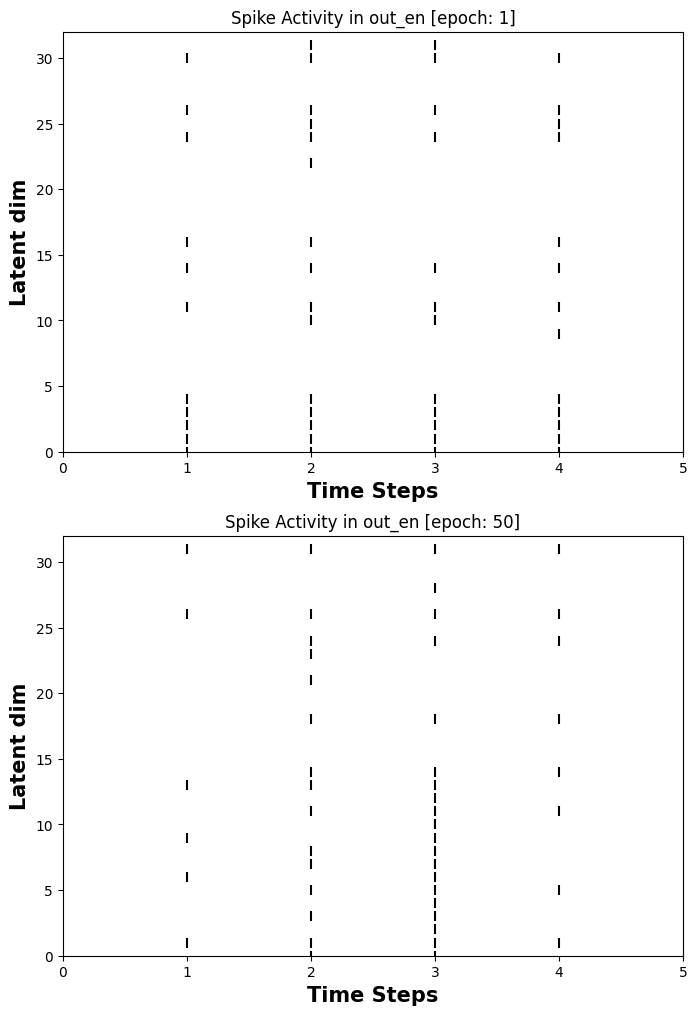

In [89]:
ax1_epoch = 1
spike_data1 = np.load(f"Output_Spikes/out_en_epoch_{ax1_epoch}.npy")

ax2_epoch = 50
spike_data2 = np.load(f"Output_Spikes/out_en_epoch_{ax2_epoch}.npy")

font_size = 15
font = {'weight': 'bold', 'size': 15}

# plt.figure(figsize=(10, 5))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# -------------------------------------------------------------------------------------- ax1
# Find the coordinates of spike events
coords = np.argwhere(spike_data1)
ax1.scatter(coords[:, 1], coords[:, 0], s=60, marker="|", color="black")
ax1.set_xlim(0, spike_data1.shape[1])
ax1.set_ylim(0, spike_data1.shape[0])
# Label the axes
ax1.set_xlabel("Time Steps", fontweight="bold", fontdict=font)
ax1.set_ylabel("Latent dim", fontweight="bold", fontdict=font)
ax1.set_title("Spike Activity in out_en" + " [epoch: " + str(ax1_epoch) + "]")
# ax1.legend(["epoch: " + str(ax1_epoch)], frameon=True, fancybox=True, shadow=True, prop={'size': 10})
# -------------------------------------------------------------------------------------- ax2
coords = np.argwhere(spike_data2)
ax2.scatter(coords[:, 1], coords[:, 0], s=60, marker="|", color="black")
ax2.set_xlim(0, spike_data2.shape[1])
ax2.set_ylim(0, spike_data2.shape[0])

# Label the axes
ax2.set_xlabel("Time Steps", fontweight="bold", fontdict=font)
ax2.set_ylabel("Latent dim", fontweight="bold", fontdict=font)
ax2.set_title("Spike Activity in out_en" + " [epoch: " + str(ax2_epoch) + "]")
# ax2.legend(["epoch: " + str(ax2_epoch)], frameon=True, fancybox=True, shadow=True, prop={'size': 10})
# --------------------------------------------------------------------------------------

# Save and display the plot
filename1 = f"Enc_b_syn_{beta_syn}_spike_epoch_{ax1_epoch}_VS_{ax2_epoch}_of_{epochs}_raster.pdf"
fig.savefig(filename1, format="pdf")

# filename2 = f"Enc_b_syn_{beta_syn}_spike_epoch_{ax2_epoch}_of_{epochs}_raster.pdf"
# fig.savefig(filename2, format="pdf")

plt.show()


## 3D plot of the Encoder sppikes

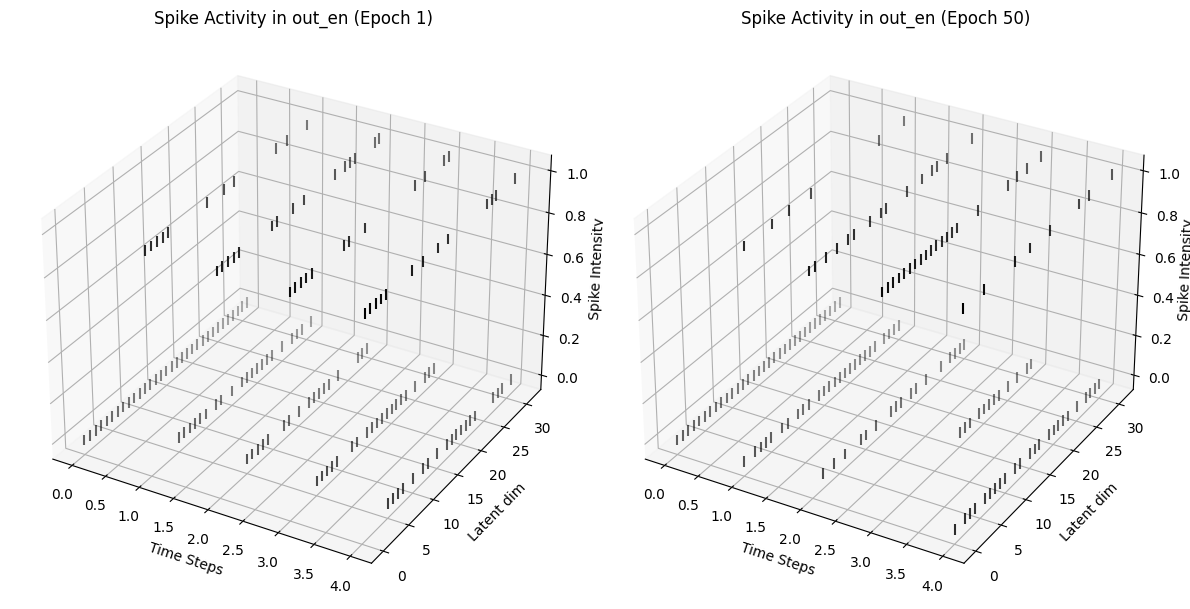

In [119]:
from mpl_toolkits.mplot3d import Axes3D

ax1_epoch = 1
spike_data1 = np.load(f"Output_Spikes/out_en_epoch_{ax1_epoch}.npy")

ax2_epoch = 50
spike_data2 = np.load(f"Output_Spikes/out_en_epoch_{ax2_epoch}.npy")

# Create a figure with subplots
fig = plt.figure(figsize=(12, 6))

# Create the first subplot for spike_data1
ax1 = fig.add_subplot(121, projection='3d')
x1, y1 = np.meshgrid(np.arange(spike_data1.shape[1]), np.arange(spike_data1.shape[0]))
z1 = spike_data1.flatten()
ax1.scatter(x1.flatten(), y1.flatten(), z1, s=60, marker="|", color="black")
ax1.set_xlabel("Time Steps")
ax1.set_ylabel("Latent dim")
ax1.set_zlabel("Spike Intensity", labelpad=2)
ax1.set_title(f"Spike Activity in out_en (Epoch {ax1_epoch})")

# Create the second subplot for spike_data2
ax2 = fig.add_subplot(122, projection='3d')
x2, y2 = np.meshgrid(np.arange(spike_data2.shape[1]), np.arange(spike_data2.shape[0]))
z2 = spike_data2.flatten()
ax2.scatter(x2.flatten(), y2.flatten(), z2, s=60, marker="|", color="black")
ax2.set_xlabel("Time Steps")
ax2.set_ylabel("Latent dim")
ax2.set_zlabel("Spike Intensity", labelpad=0.1)
ax2.set_title(f"Spike Activity in out_en (Epoch {ax2_epoch})")

# Adjust spacing between subplots
plt.tight_layout()
# Manually adjust the position of the second subplot
# pos = ax2.get_position()
# pos.x0 += 0.1  # Adjust the left position
# pos.x1 += 0.1  # Adjust the right position
# ax2.set_position(pos)

# Save and display the plot
filename = f"Enc_b_syn_{beta_syn}_spike_epochs_{ax1_epoch}_VS_{ax2_epoch}_of_{epochs}_3D.pdf"
plt.savefig(filename, format="pdf")
plt.show()


# Decoder plotting each epochs output of out:

## cmap plotting Decoder of (for one digit at the last time t)

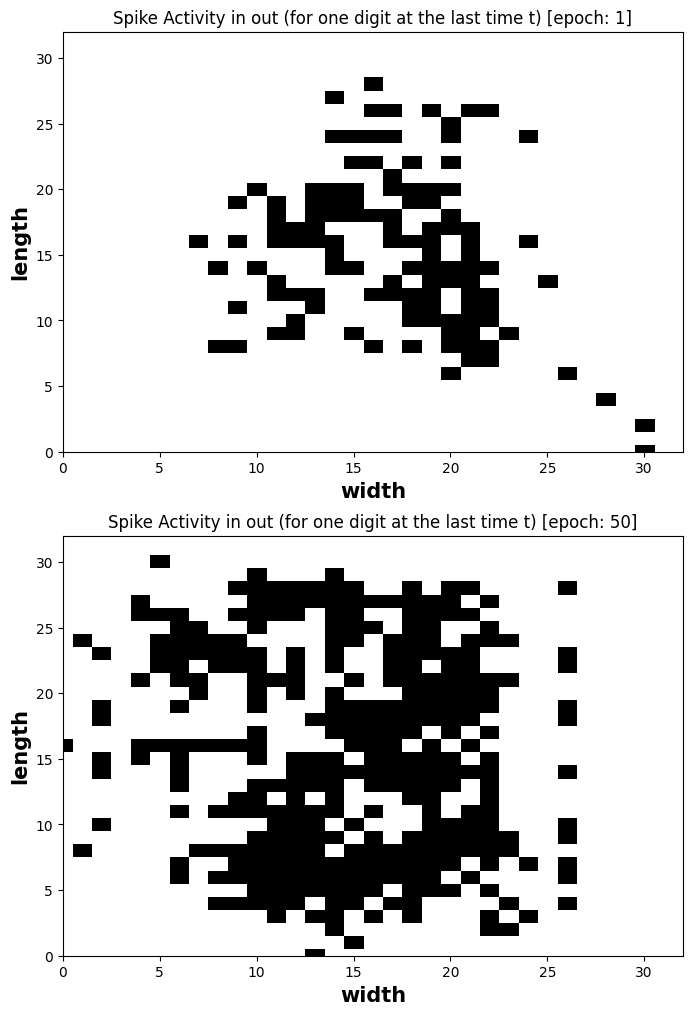

In [92]:
ax1_epoch = 1
spike_data1 = np.load(f"Output_Spikes/out_epoch_{ax1_epoch}.npy")
spike_data1 = spike_data1[0,0,:, :]
ax2_epoch = 50
spike_data2 = np.load(f"Output_Spikes/out_epoch_{ax2_epoch}.npy")
spike_data2 = spike_data2[0,0,:, :]

font_size = 15
font = {'weight': 'bold', 'size': 15}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# -------------------------------------------------------------------------------------- ax1
cmap = plt.get_cmap("binary")
ax1.imshow(spike_data1, cmap=cmap, aspect="auto")
ax1.set_xlim(0, spike_data1.shape[1])
ax1.set_ylim(0, spike_data1.shape[0])
# Label the axes
ax1.set_xlabel("width", fontweight="bold", fontdict=font)
ax1.set_ylabel("length", fontweight="bold", fontdict=font)
ax1.set_title("Spike Activity in out (for one digit at the last time t)" + " [epoch: " + str(ax1_epoch) + "]")
# ax1.legend(["epoch: " + str(ax1_epoch)], frameon=True, fancybox=True, shadow=True, prop={'size': 10})
# -------------------------------------------------------------------------------------- ax2
cmap = plt.get_cmap("binary")
ax2.imshow(spike_data2, cmap=cmap, aspect="auto")
ax2.set_xlim(0, spike_data2.shape[1])
ax2.set_ylim(0, spike_data2.shape[0])

# Label the axes
ax2.set_xlabel("width", fontweight="bold", fontdict=font)
ax2.set_ylabel("length", fontweight="bold", fontdict=font)
ax2.set_title("Spike Activity in out (for one digit at the last time t)" + " [epoch: " + str(ax2_epoch) + "]")
# ax2.legend(["epoch: " + str(ax2_epoch)], frameon=True, fancybox=True, shadow=True, prop={'size': 10})
# --------------------------------------------------------------------------------------

# Save and display the plot
filename1 = f"Dec_b_syn_{beta_syn}_spike_epoch_{ax1_epoch}_VS_{ax2_epoch}_of_{epochs}_cmap.pdf"
fig.savefig(filename1, format="pdf")

# filename2 = f"Enc_b_syn_{beta_syn}_spike_epoch_{ax2_epoch}_of_{epochs}_cmap.pdf"
# fig.savefig(filename2, format="pdf")

plt.show()



## Raster plot Decoder of (for one digit at the last time t)

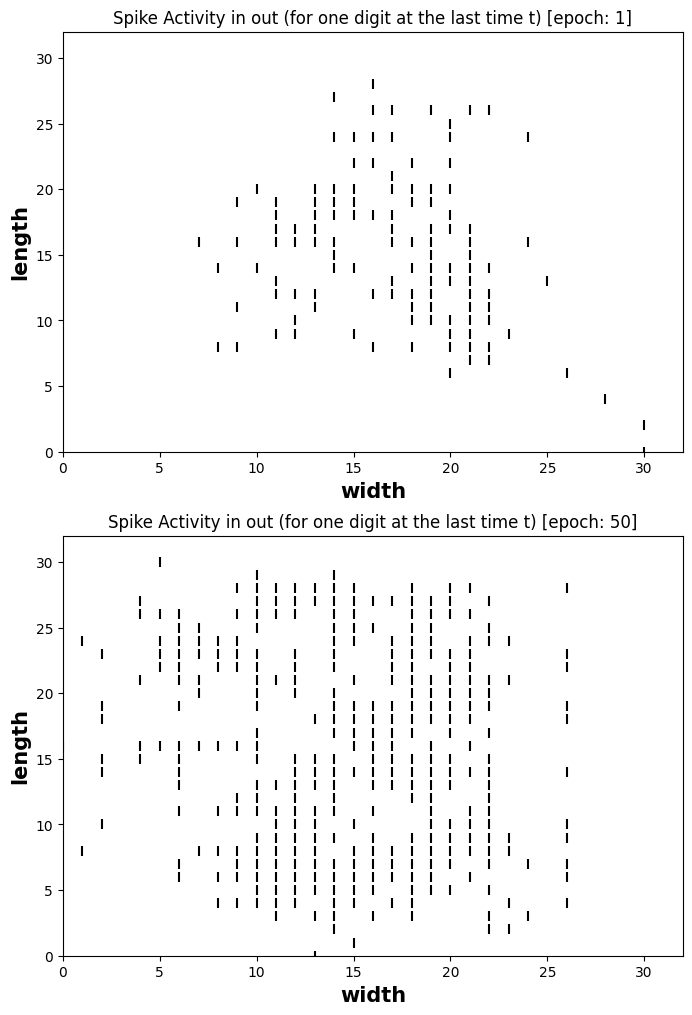

In [93]:
ax1_epoch = 1
spike_data1 = np.load(f"Output_Spikes/out_epoch_{ax1_epoch}.npy")
spike_data1 = spike_data1[0,0,:, :]
ax2_epoch = 50
spike_data2 = np.load(f"Output_Spikes/out_epoch_{ax2_epoch}.npy")
spike_data2 = spike_data2[0,0,:, :]

font_size = 15
font = {'weight': 'bold', 'size': 15}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# -------------------------------------------------------------------------------------- ax1
coords = np.argwhere(spike_data1)
ax1.scatter(coords[:, 1], coords[:, 0], s=60, marker="|", color="black")
ax1.set_xlim(0, spike_data1.shape[1])
ax1.set_ylim(0, spike_data1.shape[0])
# Label the axes
ax1.set_xlabel("width", fontweight="bold", fontdict=font)
ax1.set_ylabel("length", fontweight="bold", fontdict=font)
ax1.set_title("Spike Activity in out (for one digit at the last time t)" + " [epoch: " + str(ax1_epoch) + "]")
# ax1.legend(["epoch: " + str(ax1_epoch)], frameon=True, fancybox=True, shadow=True, prop={'size': 10})
# -------------------------------------------------------------------------------------- ax2
coords = np.argwhere(spike_data2)
ax2.scatter(coords[:, 1], coords[:, 0], s=60, marker="|", color="black")
ax2.set_xlim(0, spike_data2.shape[1])
ax2.set_ylim(0, spike_data2.shape[0])

# Label the axes
ax2.set_xlabel("width", fontweight="bold", fontdict=font)
ax2.set_ylabel("length", fontweight="bold", fontdict=font)
ax2.set_title("Spike Activity in out (for one digit at the last time t)" + " [epoch: " + str(ax2_epoch) + "]")
# ax2.legend(["epoch: " + str(ax2_epoch)], frameon=True, fancybox=True, shadow=True, prop={'size': 10})
# --------------------------------------------------------------------------------------

# Save and display the plot
filename1 = f"Dec_b_syn_{beta_syn}_spike_epoch_{ax1_epoch}_VS_{ax2_epoch}_of_{epochs}_raster.pdf"
fig.savefig(filename1, format="pdf")

# filename2 = f"Enc_b_syn_{beta_syn}_spike_epoch_{ax2_epoch}_of_{epochs}_cmap.pdf"
# fig.savefig(filename2, format="pdf")

plt.show()



## 3D plotting Decoder of (for one digit at the last time t)

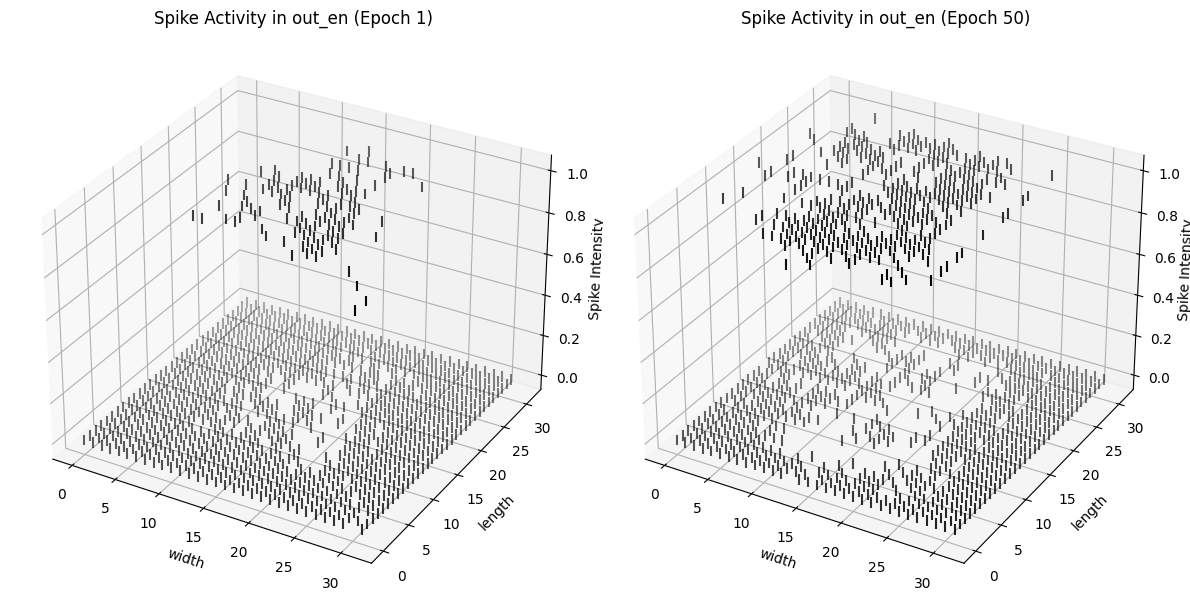

In [127]:
from mpl_toolkits.mplot3d import Axes3D

ax1_epoch = 1
spike_data1 = np.load(f"Output_Spikes/out_epoch_{ax1_epoch}.npy")
spike_data1 = spike_data1[0,0,:, :]

ax2_epoch = 50
spike_data2 = np.load(f"Output_Spikes/out_epoch_{ax2_epoch}.npy")
spike_data2 = spike_data2[0,0,:, :]

# Create a figure with subplots
fig = plt.figure(figsize=(12, 6))

# Create the first subplot for spike_data1
ax1 = fig.add_subplot(121, projection='3d')
x1, y1 = np.meshgrid(np.arange(spike_data1.shape[1]), np.arange(spike_data1.shape[0]))
z1 = spike_data1.flatten()
ax1.scatter(x1.flatten(), y1.flatten(), z1, s=60, marker="|", color="black")
ax1.set_xlabel("width")#, fontweight="bold", fontdict=font)
ax1.set_ylabel("length")#, fontweight="bold", fontdict=font)
ax1.set_zlabel("Spike Intensity", labelpad=2)#, fontweight="bold", fontdict=font)
ax1.set_title(f"Spike Activity in out_en (Epoch {ax1_epoch})")

# Create the second subplot for spike_data2
ax2 = fig.add_subplot(122, projection='3d')
x2, y2 = np.meshgrid(np.arange(spike_data2.shape[1]), np.arange(spike_data2.shape[0]))
z2 = spike_data2.flatten()
ax2.scatter(x2.flatten(), y2.flatten(), z2, s=60, marker="|", color="black")
ax2.set_xlabel("width")#, fontweight="bold", fontdict=font)
ax2.set_ylabel("length")#, fontweight="bold", fontdict=font)
ax2.set_zlabel("Spike Intensity", labelpad=0.1)#, fontweight="bold", fontdict=font)
ax2.set_title(f"Spike Activity in out_en (Epoch {ax2_epoch})")

# Adjust spacing between subplots
plt.tight_layout()
# Manually adjust the position of the second subplot
# pos = ax2.get_position()
# pos.x0 += 0.1  # Adjust the left position
# pos.x1 += 0.1  # Adjust the right position
# ax2.set_position(pos)

# Save and display the plot
filename = f"Dec_b_syn_{beta_syn}_spike_epochs_{ax1_epoch}_VS_{ax2_epoch}_of_{epochs}_3D.pdf"
plt.savefig(filename, format="pdf")
plt.show()


out: (250, 1, 32, 32)
out.reshape(-1, out.shape[-1]):  (8000, 32)


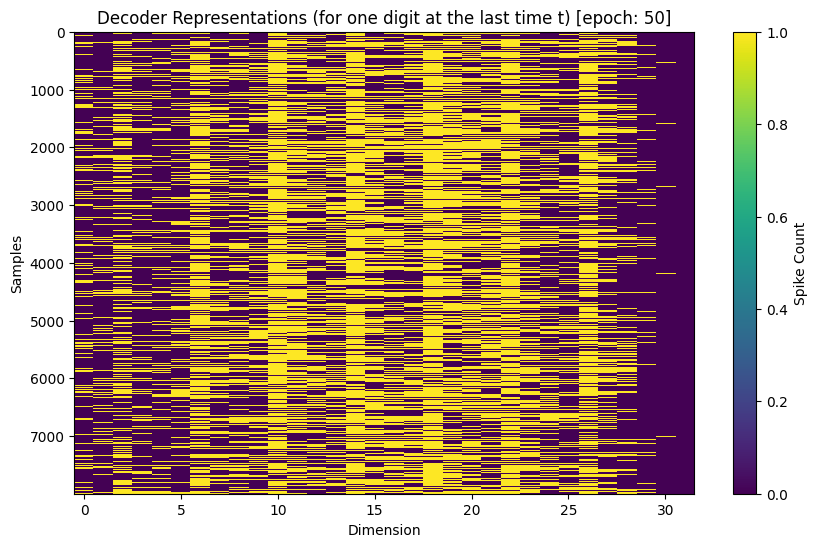

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Load the 'out' tensor for a specific epoch
epoch_number = 50  # Change this to the epoch you want to visualize
out_filename = f"out_epoch_{epoch_number}.npy"
out = np.load(out_filename)
print("out:",out.shape)  # Using .shape attribute

# Reshape the data if needed
# For example, if 'out' is a 4D tensor and you want to visualize a specific slice
# along one of the dimensions, you can reshape it to a 2D matrix for plotting.

# Example reshape (adjust dimensions as needed)
out = out.reshape(-1, out.shape[-1])  # Flatten all dimensions except the last one
print("out.reshape(-1, out.shape[-1]): ",out.shape)  # Using .shape attribute
# or
# print(out.size())  # Using .size() method
# Create a plot
plt.figure(figsize=(10, 6))
plt.imshow(out, cmap='viridis', aspect='auto', interpolation='nearest')
plt.xlabel("Dimension")
plt.ylabel("Samples")
plt.title("Decoder Representations (for one digit at the last time t)" + " [epoch: " + str(epoch_number) + "]")

plt.colorbar(label='Spike Count')

filename = f"Dec_b_syn_{beta_syn}_spike_epochs_{epoch_number}_of_{epochs}_(8000x32).pdf"
plt.savefig(filename, format="pdf")

plt.show()
